In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
sys.path.append(os.path.dirname(os.getcwd())) # Include ../SSD in path

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from vizer.draw import draw_boxes
from tops.config import instantiate, LazyConfig
from ssd import utils
np.random.seed(0)

In [4]:
from dataset_exploration.dataset_statistics import (
    statistics,
    analyze_distribution,
    analyze_bounding_boxes,
    get_config,
    get_dataloader,
)

In [5]:
# Load config
config_path = "../configs/tdt4265.py"
cfg = get_config(config_path)

It looks like you are currently working on the server, with a 'working directory' in: /work/snotra/mariueng
	If you struggle with NTNU home directory becoming full, we recommend you to change the output directory to: /work/snotra/mariueng
	 /work/snotra/mariueng does not sync with NTNU HOME, and is a directory only located on the server.
	 To change the output directory of SSD, set save_in_work to True in the file configs/utils.py, in the function get_output_dir.
Saving SSD outputs to: outputs/
Found dataset directory in: /work/datasets/mnist_object_detection/train
Found dataset directory in: /work/datasets/mnist_object_detection/val
Found dataset directory in: /work/datasets/tdt4265_2022
Found dataset file in: /work/datasets/tdt4265_2022/train_annotations.json
Found dataset directory in: /work/datasets/tdt4265_2022
Found dataset file in: /work/datasets/tdt4265_2022/val_annotations.json


In [6]:
label_map = cfg.label_map
print(f"Label map is: {label_map}")

Label map is: {0: 'background', 1: 'car', 2: 'truck', 3: 'bus', 4: 'motorcycle', 5: 'bicycle', 6: 'scooter', 7: 'person', 8: 'rider'}


In [7]:
# Get dataloader
dataset_to_analyze = "train"
dataloader_train = get_dataloader(cfg, dataset_to_analyze)

/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [8]:
# dir(dataloader_train)

all_training_images = list(dataloader_train.dataset)

In [9]:
data = next(iter(dataloader_train))

In [10]:
data.keys()

dict_keys(['image', 'boxes', 'labels', 'width', 'height', 'image_id'])

In [11]:
next_image = next(iter(dataloader_train))
print(f"Feature batch shape: {next_image['image'].size()}")
print(f"Labels batch shape: {next_image['labels'].size()}")

Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/opt/conda/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/conda/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/opt/conda/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


Feature batch shape: torch.Size([1, 3, 128, 1024])
Labels batch shape: torch.Size([1, 17])


Shape: torch.Size([128, 1024, 3])


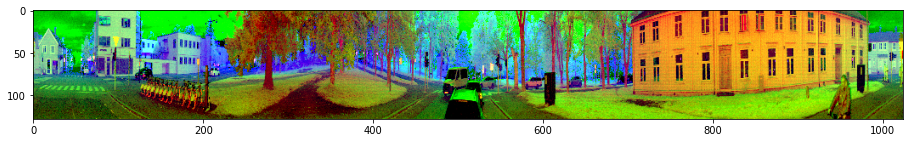

In [12]:
# Display image and label.
img = next_image['image'][0]
im2display = img.permute(1, 2, 0)
print(f'Shape: {im2display.shape}')
label = next_image['labels'][0]
fig, ax = plt.subplots(figsize=(18, 2))
ax.imshow(im2display, cmap="gray")

In [13]:
# Draw bounding boxes
dataset_to_visualize = "train"

if dataset_to_visualize == "train":
    # Remove GroundTruthBoxesToAnchors transform
    if cfg.data_train.dataset._target_ == torch.utils.data.ConcatDataset:
        for dataset in cfg.data_train.dataset.datasets:
            dataset.transform.transforms = dataset.transform.transforms[:-1]
        else:
            cfg.data_train.dataset.transform.transforms = cfg.data_train.dataset.transform.transforms[:-1]
        dataset = instantiate(cfg.data_train.dataloader)
        gpu_transform = instantiate(cfg.data_train.gpu_transform)
    else:
        cfg.data_val.dataloader.collate_fn = utils.batch_collate
        dataset = instantiate(cfg.data_val.dataloader)
        gpu_transform = instantiate(cfg.data_val.gpu_transform)

# Assumes taht the first GPU transform is Normalize
# If it fails, just change the index from 0.
image_mean = torch.tensor(cfg.data_train.gpu_transform.transforms[0].mean).view(1, 3, 1, 1)
image_std = torch.tensor(cfg.data_train.gpu_transform.transforms[0].std).view(1, 3, 1, 1)

In [14]:
sample = next(iter(dataset))
sample = gpu_transform(sample)

In [15]:
print(f"The first sample in the dataset the following keys: {sample.keys()}")
for key, item in sample.items():
    print(key, ": shape=", item.shape if hasattr(item, "shape") else "", 
          " dtype=", item.dtype if hasattr(item, "dtype") else type(item), sep="")

The first sample in the dataset the following keys: dict_keys(['image', 'boxes', 'labels', 'width', 'height', 'image_id'])
image: shape=torch.Size([1, 3, 128, 1024]) dtype=torch.float32
boxes: shape=torch.Size([1, 14, 4]) dtype=torch.float32
labels: shape=torch.Size([1, 14]) dtype=torch.int64
width: shape=torch.Size([1]) dtype=torch.int64
height: shape=torch.Size([1]) dtype=torch.int64
image_id: shape=torch.Size([1]) dtype=torch.int64


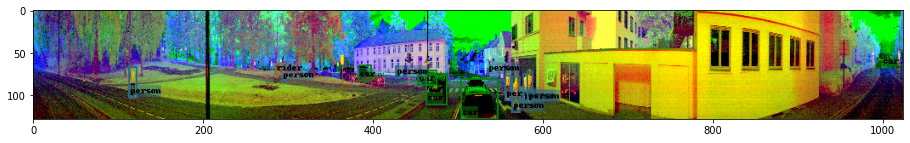

In [16]:
# Convert image to HWC byte
image = (sample["image"] * image_std + image_mean)
image = (image * 255).byte()[0]
im = image.permute(1, 2, 0).cpu().numpy()

# Convert boxes to pixel coordinates
boxes = sample["boxes"][0]
boxes[:, [0, 2]] *= image.shape[-1]  # width
boxes[:, [1, 3]] *= image.shape[-2]  # height

# Draw boxes on image, params: image, boxes with pixel coordinates, label value, label names.
im_with_boxes = draw_boxes(im, boxes.cpu().numpy(), sample["labels"][0].cpu().numpy().tolist(), class_name_map=cfg.label_map)

concat_im = np.concatenate([im, im_with_boxes], axis=0)

#fig, ax = plt.subplot(figsize=(18, 2))
#plt.imshow(im)
fig, ax = plt.subplots(figsize=(18, 2))
ax.imshow(im_with_boxes)
#plt.show()

In [14]:
statistics(dataloader_train, cfg)

ValueError: too many values to unpack (expected 3)

In [19]:
dir(dataloader_train)

['_DataLoader__initialized',
 '_DataLoader__multiprocessing_context',
 '_IterableDataset_len_called',
 '__annotations__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_auto_collation',
 '_dataset_kind',
 '_get_iterator',
 '_index_sampler',
 '_is_protocol',
 '_iterator',
 'batch_sampler',
 'batch_size',
 'check_worker_number_rationality',
 'collate_fn',
 'dataset',
 'drop_last',
 'generator',
 'multiprocessing_context',
 'num_workers',
 'persistent_workers',
 'pin_memory',
 'prefetch_factor',
 'sampler',
 'timeout',
 'worker_init_fn']